In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy.random import rand, normal
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Constants

In [3]:
f12 = 0.4162                  # Oscillator strength
c   = 2.99792458e10           # Speed of light (cm/sec)
ν0  = 2.466e15                # Lya frequency (Hz)
λ0  = c / ν0                  # Lya wavelength (cm)
ΔνL = 9.936e7                 # Natural line width (Hz)
me  = 9.109382917e-28         # Electron mass (g)
ee  = 4.80320451e-10          # Electron charge in g^(1/2) cm^(3/2) / s
kB  = 1.380648813e-16         # Boltzmann's constant (g cm^2/sec^2/k)
mH  = 1.6735327e-24           # Mass of hydrogen atom (g)
h   = 6.626069573e-27         # Planck's constant (erg s)

km  = 1e5                     # Units: 1 km = 1e5  cm
pc  = 3.085677581467192e18    # Units: 1 pc = 3e18 cm

# Thermal velocity: vth_div_sqrtT = vth / sqrt(T)
vth_div_sqrtT = np.sqrt(2. * kB / mH)
# Doppler width: ΔνD_div_sqrtT = ΔνD / sqrt(T)  (ΔνD = ν0*vth/c)
ΔνD_div_sqrtT = ν0 * vth_div_sqrtT / c
# "damping parameter": a_sqrtT = a * sqrt(T)
a_sqrtT = c * ΔνL * mH / (2. * ν0 * np.sqrt(2. * kB * mH))
# Cross section: σ0_sqrtT = σ0 * sqrt(T)
σ0_sqrtT = np.sqrt(np.pi/2) * f12 * ee * ee * np.sqrt(mH/kB) / (me * ν0)

# Initial Conditions

In [4]:
aτ0  = 1e7  # Optically thick if a * tau0 > 1000
T    = 1e4  # Temperature (K)
zmax = 1.   # Center-to-edge distance in plane parallel geometry
xmax = 2.5 * aτ0**(1./3.) # Maximum frequency
nz   = 101  # Number of spatial cells
nx   = 51   # Number of frequency bins
# nz   = 75   # Number of spatial cells
# nx   = 41   # Number of frequency bins
# nz   = 49   # Number of spatial cells
# nx   = 31   # Number of frequency bins
z_edges = np.linspace(-zmax,zmax,nz+1)
x_edges = np.linspace(-xmax,xmax,nx+1)
z    = (z_edges[1:] + z_edges[:-1]) / 2.
x    = (x_edges[1:] + x_edges[:-1]) / 2.
Δz   = z_edges[1:] - z_edges[:-1]
Δx   = x_edges[1:] - x_edges[:-1]
z0   = 0.   # Emission at z = 0
x0   = 0.   # Emission at x = 0
iz0  = np.argmin(np.abs(z - z0))
ix0  = np.argmin(np.abs(x - x0))

## Derived parameters ##
vth  = vth_div_sqrtT * np.sqrt(T)     # Thermal velocity (cm/s)
ΔνD  = ΔνD_div_sqrtT * np.sqrt(T)     # Doppler width (Hz)
a    = a_sqrtT / np.sqrt(T)           # "damping parameter"
τ0   = aτ0 / a                        # Optical depth at line center
σ0   = σ0_sqrtT / np.sqrt(T)          # Cross-section at line center (cm^2)
k0   = τ0 / zmax                      # Absorption coefficient (cm^-1)
N0   = τ0 / σ0                        # Column density (cm^-2)
n0   = N0 / zmax                      # Number density (cm^-3)
# Core-wing transition frequency: exp(-x_cw^2) ~ a / (sqrt(pi) x_cw^2)
x_cw = fsolve(lambda y : np.exp(-y*y) - a / (np.sqrt(np.pi) * y*y), 0.5)[0]

## Print Lyman-alpha properties ##
print('Lyman-alpha properties:'
      f'\n  aτ0  = {aτ0}'
      f'\n  T    = {T} K'
      f'\n  zmax = {zmax} cm'
      f'\n  xmax = {xmax}'
      f'\n  nz   = {nz}\t(z0={z0}, iz0={iz0})'
      f'\n  nx   = {nx}\t(x0={x0}, iz0={ix0})\n'
      f'\n  x_cw = {x_cw}'
      f'\n  vth  = {vth/km} km/s'
      f'\n  ΔνD  = {ΔνD/1e9} GHz'
      f'\n  a    = {a}'
      f'\n  τ0   = {τ0}'
      f'\n  σ0   = {σ0} cm^2'
      f'\n  k0   = {k0} cm^-1'
      f'\n  N0   = {N0} cm^-2'
      f'\n  n0   = {n0} cm^-3')

Lyman-alpha properties:
  aτ0  = 10000000.0
  T    = 10000.0 K
  zmax = 1.0 cm
  xmax = 538.6086725079708
  nz   = 101	(z0=0.0, iz0=50)
  nx   = 51	(x0=0.0, iz0=25)

  x_cw = 3.255018090644676
  vth  = 12.845159709869076 km/s
  ΔνD  = 105.66030932151449 GHz
  a    = 0.00047018601704854355
  τ0   = 21268178204.813705
  σ0   = 5.898174674107242e-14 cm^2
  k0   = 21268178204.813705 cm^-1
  N0   = 3.605891547800404e+23 cm^-2
  n0   = 3.605891547800404e+23 cm^-3


# Helper functions

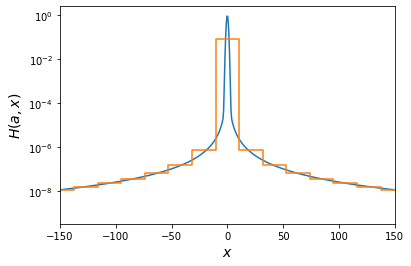

In [5]:
## Voigt function ##
from scipy.special import dawsn,erf
sqrt_pi_2 = np.sqrt(np.pi) / 2.
def H(x):
    return np.exp(-x**2) * (1. + a**2*(1.-2.*x**2)) + a*(2.*x*dawsn(x) - 1.)/sqrt_pi_2

def IH(x):
    return sqrt_pi_2*erf(x) - a*dawsn(x)/sqrt_pi_2 + a**2*x*np.exp(-x**2)

k = k0 * (IH(x_edges[1:]) - IH(x_edges[:-1])) / Δx # Average scattering coefficient

xmax_lim = 150.
x_a = np.linspace(-xmax_lim, xmax_lim, 500)
plt.semilogy(x_a, [H(x_i) for x_i in x_a])
plt.plot(x, k/k0, drawstyle='steps-mid')
plt.xlim([-xmax_lim,xmax_lim])
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$H(a,x)$', fontsize=14)
plt.show()

# Lyman-alpha Radiative Transfer

* Psuedo-code

    Initialize photon position (cell) and frequency (bin)
    
    Loop until photon escapes (iz < 0 or iz >= nz):
        Check spatial leakage:
$
\begin{align}
k_{z\text{-leak}}^{\delta i} = \frac{1}{3\Delta z_i} \frac{2}{k_{i,j} \Delta z_i + k_{\delta i,j} \Delta z_{\delta i}} \quad \Rightarrow \quad \lambda_{z\text{-leak}}^{\delta i} = 3 k_j (\Delta z)^2 \quad \text{(isothermal, uniform slab, constant} \, \Delta z \, \text{spacing)}
\end{align}
$
        Check frequency leakage:
$
\begin{align}
k_{x\text{-leak}}^{\delta j} = \frac{1}{\Delta x_j} \frac{1}{k_{i,j}^{-1} \Delta x_j + k_{i,\delta j}^{-1} \Delta x_{\delta j}}  \quad \Rightarrow \quad \lambda_{x\text{-leak}}^{\delta j} = \left(k_j^{-1} + k_{\delta j}^{-1} \right) (\Delta x)^2 \quad \text{(isothermal, uniform slab, constant} \, \Delta x \, \text{spacing)}
\end{align}
$
        Update photon position (cell) or frequency (bin) according to the minimum interaction distance
$
\begin{align}
\Delta \ell = \min_{\delta i, \delta j} \left( \Delta \ell_{z\text{-leak}}^{\delta i}, \Delta \ell_{x\text{-leak}}^{\delta j} \right) \quad \text{where} \quad \Delta \ell_X = -\lambda_{\text{mfp},X} \ln \xi
\end{align}
$

In [6]:
## Track a single photon to escape ##
MOVE_LEFT  = 0
MOVE_RIGHT = 1
FREQ_LEFT  = 2
FREQ_RIGHT = 3
action_str = ['MOVE_LEFT', 'MOVE_RIGHT', 'FREQ_LEFT', 'FREQ_RIGHT']

λz = 3. * k * Δz[0]**2 # Mean free path for spatial leakage
k_inv = np.hstack([np.inf, 1./k[1:] + 1./k[:-1], np.inf])
λxL = k_inv[:-1] * Δx**2 # Mean free path for frequency leakage (left)
λxR = k_inv[1:] * Δx**2  # Mean free path for frequency leakage (right)

def photon():
    iz = iz0                    # Initialize each photon at the center of the slab
    ix = ix0                    # Initialize each photon at line center: x = (ν - ν0) / ΔνD
    while True:
        Δl_min = np.inf
        ## Check spatial leakage (left)
        Δl_z_L = -np.log(rand()) * λz[ix] # Δl = -ln(R) / k_leak
        if Δl_z_L < Δl_min:
            action = MOVE_LEFT
            Δl_min = Δl_z_L
        ## Check spatial leakage (right)
        Δl_z_R = -np.log(rand()) * λz[ix] # Δl = -ln(R) / k_leak
        if Δl_z_R < Δl_min:
            action = MOVE_RIGHT
            Δl_min = Δl_z_R
        ## Check frequency leakage (left)
        Δl_x_L = -np.log(rand()) * λxL[ix] # Δl = -ln(R) / k_leak
        if Δl_x_L < Δl_min:
            action = FREQ_LEFT
            Δl_min = Δl_x_L
        ## Check frequency leakage (right)
        Δl_x_R = -np.log(rand()) * λxR[ix] # Δl = -ln(R) / k_leak
        if Δl_x_R < Δl_min:
            action = FREQ_RIGHT
            Δl_min = Δl_x_R
        ## Update photon position (cell) or frequency (bin)
        if action == MOVE_LEFT:
            iz -= 1
            if iz < 0:
                break # Photon escapes through left boundary
        elif action == MOVE_RIGHT:
            iz += 1
            if iz >= nz:
                break # Photon escapes through right boundary
        elif action == FREQ_LEFT:
            ix -= 1
        elif action == FREQ_RIGHT:
            ix += 1
    return x[ix]

In [9]:
## Run simulation ##
n_photons = 2000  # Number of Monte-Carlo photon packets
xs = np.array([photon() for i in range(n_photons)])

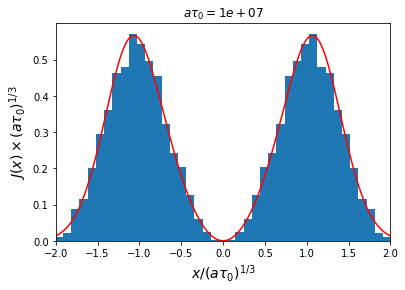

In [10]:
## Plot results ##
aτ0_1_3 = aτ0**(1./3.)
plt.hist(np.hstack([xs,-xs])/aτ0_1_3, bins=nx, range=(-xmax/aτ0_1_3,xmax/aτ0_1_3), density=True)
# plt.hist(xs/aτ0_1_3, bins=nx, range=(-xmax/aτ0_1_3,xmax/aτ0_1_3), density=True)
xa = np.linspace(-xmax, xmax, 250)
Ja = np.sqrt(np.pi/6.)*xa**2/aτ0/np.cosh(np.sqrt(np.pi**3/54.)*xa**3/aτ0)
plt.plot(xa/aτ0_1_3, Ja*aτ0_1_3, 'r')
plt.xlabel(r'$x / (a \tau_0)^{1/3}$', fontsize=14)
plt.ylabel(r'$J(x) \times (a \tau_0)^{1/3}$', fontsize=14)
plt.gca().set_xlim([-2.,2.]);
plt.title(r"$a\tau_0 = %g$" % (aτ0))
plt.savefig('J_rDDMC.pdf', bbox_inches='tight')